## 1. Simulating Realistic Shipping Sensor Data
First, let's simulate more realistic sensor data that could be collected from a ship:

- Engine Temperature (°C)
- Vibration Level (mm/s)
- Fuel Consumption (tons/day)
- Oil Pressure (bar)
- Hull Stress Level (% of maximum)

We'll also simulate maintenance events based on certain thresholds that indicate when maintenance is needed.


In [7]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
data_size = 1000

# Simulate sensor data
engine_temp = np.random.normal(loc=85, scale=5, size=data_size)  # Normal operating temp around 85°C
vibration = np.random.normal(loc=5, scale=1.5, size=data_size)   # Normal vibration levels
fuel_consumption = np.random.normal(loc=50, scale=5, size=data_size)  # Average fuel consumption
oil_pressure = np.random.normal(loc=3, scale=0.5, size=data_size)     # Oil pressure in bar
hull_stress = np.random.normal(loc=50, scale=10, size=data_size)      # Hull stress percentage

# Simulate maintenance events based on thresholds
maintenance_needed = (
    (engine_temp > 90) |
    (vibration > 7) |
    (fuel_consumption > 60) |
    (oil_pressure < 2.5) |
    (hull_stress > 70)
).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'engine_temp': engine_temp,
    'vibration': vibration,
    'fuel_consumption': fuel_consumption,
    'oil_pressure': oil_pressure,
    'hull_stress': hull_stress,
    'maintenance_needed': maintenance_needed
})

# Display first few rows
print(df.head())


   engine_temp  vibration  fuel_consumption  oil_pressure  hull_stress  \
0    87.483571   7.099033         46.624109      2.046096    41.365064   
1    84.308678   6.386951         49.277407      2.569807    49.687965   
2    88.238443   5.089446         46.037900      2.793197    50.180169   
3    92.615149   4.029595         48.460192      3.943844    54.726303   
4    83.829233   6.047335         40.531927      3.278277    36.331416   

   maintenance_needed  
0                   1  
1                   0  
2                   0  
3                   1  
4                   0  


2. Visualizing the Data
Let's visualize the distribution of each sensor reading and see how they relate to maintenance events.

c:\Users\craigparker\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\craigparker\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\craigparker\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\craigparker\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wi

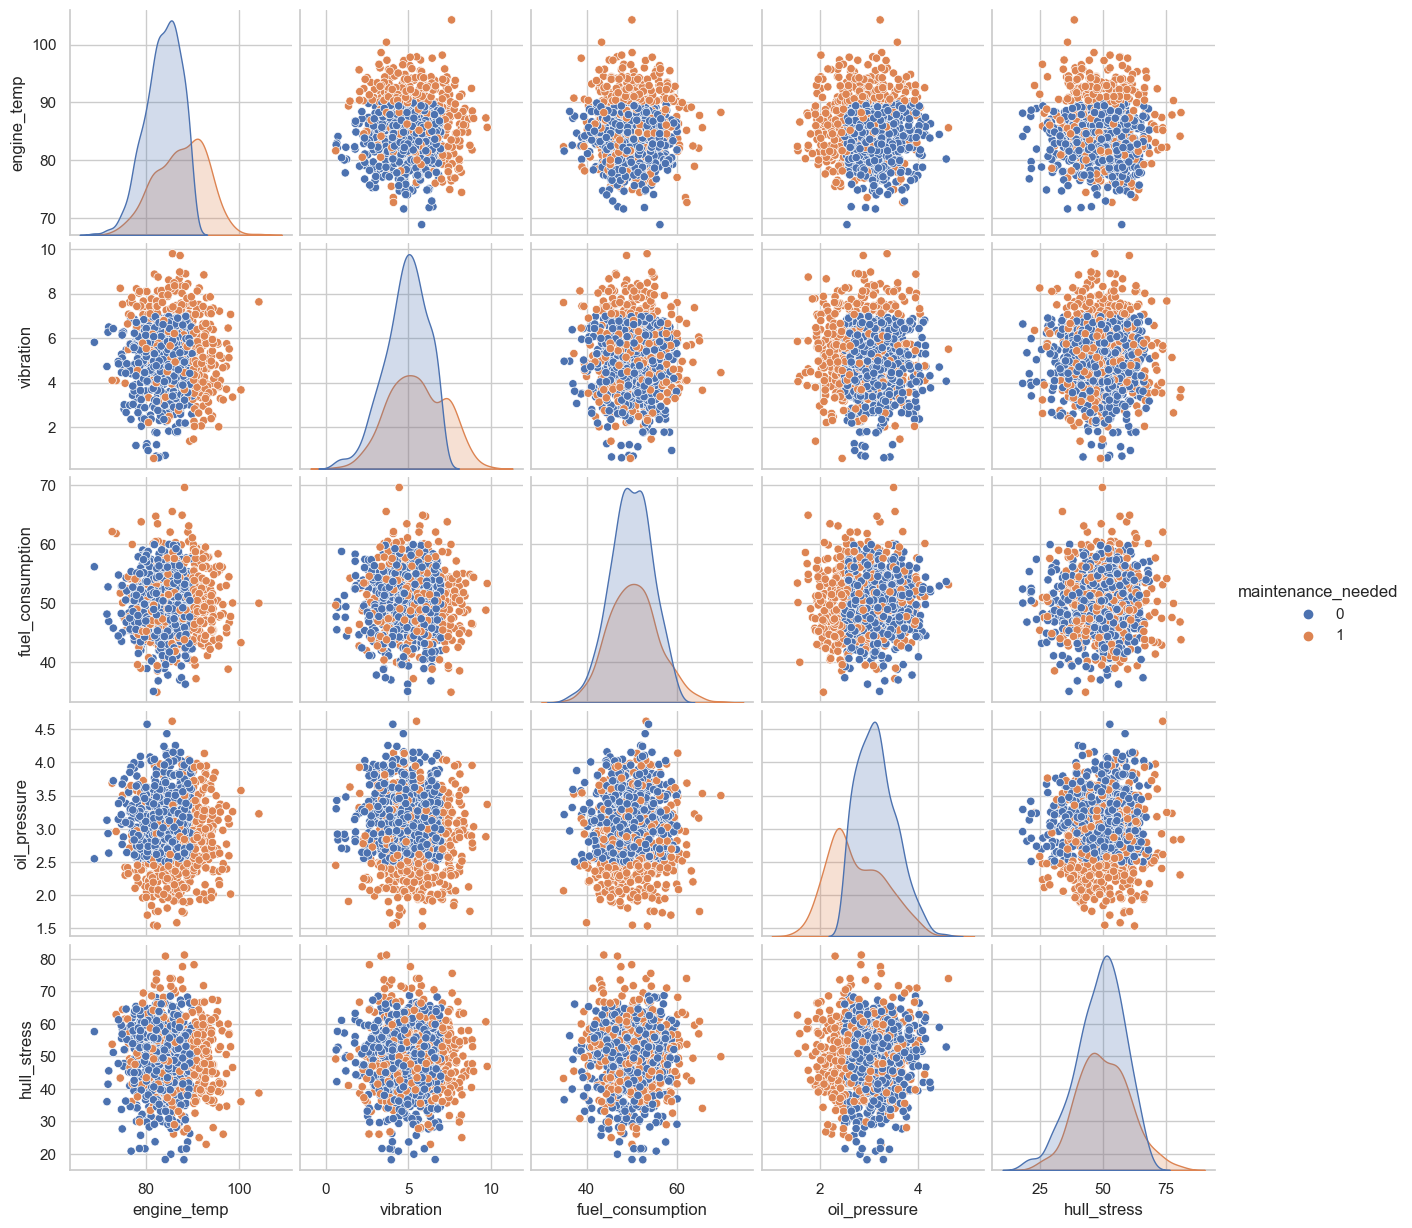

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

# Pairplot to visualize pairwise relationships
sns.pairplot(df, hue='maintenance_needed', vars=['engine_temp', 'vibration', 'fuel_consumption', 'oil_pressure', 'hull_stress'])
plt.show()


Visualization:


This pairplot helps us understand the relationships between different sensor readings and how they correlate with the need for maintenance.

3. Preparing the Data for Modeling
Split the data into training and testing sets to evaluate the model's performance on unseen data.

In [9]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = df.drop('maintenance_needed', axis=1)
y = df['maintenance_needed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


4. Training a Random Forest Classifier
The Random Forest algorithm is a powerful ensemble method suitable for classification tasks.

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

5. Evaluating the Model

In [11]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       122
           1       0.97      0.99      0.98        78

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



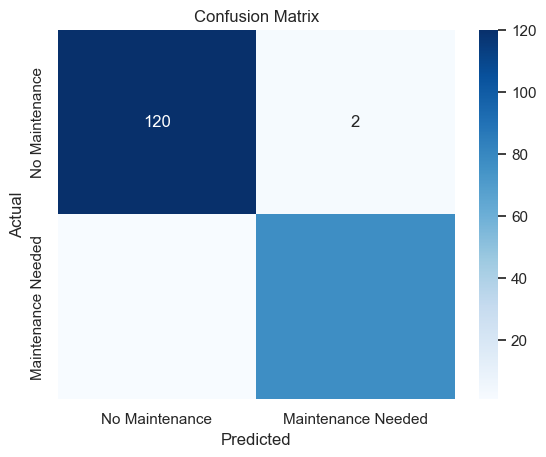

In [12]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Maintenance', 'Maintenance Needed'],
            yticklabels=['No Maintenance', 'Maintenance Needed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Visualization:


This confusion matrix shows that our model correctly predicted most maintenance events.

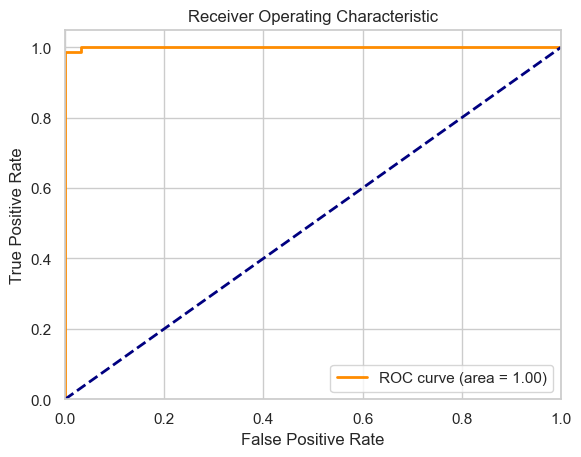

In [13]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


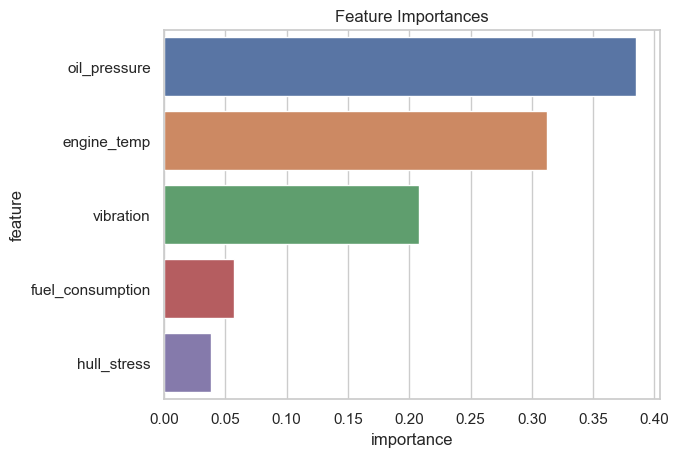

In [14]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot feature importances
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


In [15]:
def predict_maintenance(sensor_readings):
    """
    Predict maintenance need based on sensor readings.
    Parameters:
        sensor_readings (dict): Dictionary of sensor readings.
    Returns:
        int: 0 if maintenance not needed, 1 if maintenance needed.
    """
    # Create DataFrame
    input_df = pd.DataFrame([sensor_readings])
    return model.predict(input_df)[0]


In [16]:
# New sensor readings
new_sensor_readings = {
    'engine_temp': 92,       # °C
    'vibration': 6.5,        # mm/s
    'fuel_consumption': 55,  # tons/day
    'oil_pressure': 2.8,     # bar
    'hull_stress': 65        # %
}

# Predict maintenance need
maintenance_needed = predict_maintenance(new_sensor_readings)
print(f"Maintenance needed: {'Yes' if maintenance_needed else 'No'}")


Maintenance needed: Yes
